In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import time
import pandas as pd
import os
import copy
from matplotlib import pyplot as plt
import re
import string
import nltk

In [4]:
# TO DO AFTER : make it more automated (parameters)

# Definition of the CNN based discrimantor, inheriting from nn.Module super class
class CNNDiscriminator(nn.Module):
    
    # Constructor of the Discrimator
    def __init__(self, batch_size=8, max_seq=5, voc_size=50, embedding_dim=10, 
                 window_sizes=[1,2,3], n_filters = [300,300,300], n_features_maps=900, n_inter_nodes=200):
                
        # Call the superclass' constructor
        super(CNNDiscriminator, self).__init__()
        
        # Embedding
        self.embedding = nn.Embedding(voc_size, embedding_dim) # Why padding in the TextGan version ? 
        
#         self.conv = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(2,10), stride=1, padding=0)
        
        self.tan_layer = nn.Tanh()
        
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=f, kernel_size=(h,10), stride=1, padding=0) 
            for h,f in zip(window_sizes, n_filters)
        ])
        
        self.n_features_maps = sum(n_filters)
     
        # Definition of the classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.n_features_maps, out_features=n_inter_nodes),
            nn.Sigmoid(),
            nn.Linear(in_features=n_inter_nodes, out_features=2),
            nn.Softmax(dim=1)) # Quid formule Text Gan ??? 
        
        # Call the parameters initialization function
#         self.init_params() 
    
    def perform_convolution(self, x):
        
        outputs = [conv(x).squeeze(3) for conv in self.conv_layers] # Apply convolutional with filters size and number of filters
        outputs = [self.tan_layer(output) for output in outputs] # Apply tanh function
        poolings = [nn.MaxPool1d(output.size(2))for output in outputs] # Prepare the max-pooling filters over time
        outputs = [pool(output).squeeze(2) for output, pool in zip(outputs, poolings)] # Applying max-pooling filters
        output = torch.cat(outputs,1)
        return output
        
#         outputs = []
#         for h, f in zip([1,2,3], [300,300,300]):
#             conv_h = nn.Conv2d(in_channels=1, out_channels=f, kernel_size=(h,10), stride=1, padding=0)
#             output_h = conv_h(x).squeeze(3)
            
#             pool_h = nn.MaxPool1d(output_h.size(2))
            
#             output_h = self.tan(output_h)
            
#             output_h = pool_h(output_h).squeeze(2)
            
#             outputs.append(output_h)
#         output = torch.cat(outputs,1)
#         return output
        
    # Overwriting the base forward function in nn.Module 
    def forward(self, x):
        
        # Retrieve the embedding of the words
        output = self.embedding(x).unsqueeze(1)
#         display('Output shape after embedding : ', output.shape) # batch_size * 1 * max_seq_len * embed_dim

#         # Convolutional phase
#         output = self.conv(output).squeeze(3)
#         self.pool = nn.MaxPool1d(output.size(2))
#         display('Output shape after convolution : ', output.shape) # batch_size * num_filter * length
        
#         # Tanh phase
#         output = self.tan(output)
#         display('Output shape after tanh : ', output.shape) # batch_size * num_filter * length
        
#         # Pooling phase
#         output = self.pool(output).squeeze(2)
#         display('Output shape after pooling : ', output.shape) # batch_size * num_filter
        
        # Whole convolutional layer with several filters
        output = self.perform_convolution(output)
#         display('Output shape after whole convolutional layers:', output.shape) # batch_size * num_filter

        # Return the final output
        output = self.classifier(output)
#         display('Output shape after classifier:', output.shape) # batch_size * num_classes
        return output
    
    # Initiate the parameters to a normal distribution with a mean of 0 and a standard deviation of 1
#     def init_params(self):
#         for param in self.parameters():
#             if param.requires_grad:
#                 torch.nn.init.normal_(param, mean=0, std=1)
                
discriminator = CNNDiscriminator()

# ngpu = 0 # Number of GPUs available. Use 0 for CPU mode.
# device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu") # Decide which device we want to run on
# Enables GPU computing to speed up network training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# print(discriminator)

class MyDataset(Dataset):
    def __init__(self, values, labels):
        super(MyDataset, self).__init__()
        self.values = values
        self.labels = labels

    def __len__(self):
        return len(self.values)

    def __getitem__(self, index):
        return self.values[index], self.labels[index]

In [5]:
test = torch.randint(low=0,high=50,size=(8,5)) # 8 sentences of 5 words
display(test)
a = discriminator(test)
display(a)

tensor([[46, 20, 12,  1, 16],
        [44, 17,  5, 29,  6],
        [13,  8, 40, 43,  4],
        [27, 40, 41, 21,  9],
        [20,  0, 11, 35, 22],
        [ 2,  6, 29, 37, 45],
        [22, 15, 15, 40, 11],
        [14, 11, 24, 10, 17]])

tensor([[0.5530, 0.4470],
        [0.5768, 0.4232],
        [0.5487, 0.4513],
        [0.5689, 0.4311],
        [0.5636, 0.4364],
        [0.5686, 0.4314],
        [0.5575, 0.4425],
        [0.5595, 0.4405]], grad_fn=<SoftmaxBackward>)

In [6]:
# Training part : features needed

num_epochs = 1
num_classes = 2
batch_size = 8
learning_rate = 0.001

criterion = nn.BCELoss() # nn.BCEWithLogitsLoss stabler ? 

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Beta1 hyperparam for Adam optimizers
# beta1 = 0.5
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

# Create a batch of data
samples = torch.randint(low=0,high=50,size=(400,5))
labels = torch.randint(low=0,high=2,size=(samples.size(0),1)).float() 
train_dataset = MyDataset(samples, labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Training
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    
    for i, (sentences, labels) in enumerate(train_loader):
        
        # Run the forward pass
        outputs = discriminator(sentences)
        true_probability = outputs[:,1].unsqueeze(1)
        loss = criterion(true_probability, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        predicted = predicted.unsqueeze(1)
        correct = (predicted == labels).sum().item() 
        acc_list.append(correct / total)
        
        # Print the results 
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/1], Step [1/50], Loss: 0.6643, Accuracy: 62.50%
Epoch [1/1], Step [2/50], Loss: 0.6608, Accuracy: 62.50%
Epoch [1/1], Step [3/50], Loss: 0.5828, Accuracy: 75.00%
Epoch [1/1], Step [4/50], Loss: 0.7352, Accuracy: 62.50%
Epoch [1/1], Step [5/50], Loss: 0.9316, Accuracy: 37.50%
Epoch [1/1], Step [6/50], Loss: 0.8088, Accuracy: 37.50%
Epoch [1/1], Step [7/50], Loss: 0.8178, Accuracy: 12.50%
Epoch [1/1], Step [8/50], Loss: 0.7057, Accuracy: 50.00%
Epoch [1/1], Step [9/50], Loss: 0.9488, Accuracy: 12.50%
Epoch [1/1], Step [10/50], Loss: 0.6472, Accuracy: 62.50%
Epoch [1/1], Step [11/50], Loss: 0.6805, Accuracy: 37.50%
Epoch [1/1], Step [12/50], Loss: 0.7056, Accuracy: 62.50%
Epoch [1/1], Step [13/50], Loss: 0.7944, Accuracy: 37.50%
Epoch [1/1], Step [14/50], Loss: 0.7195, Accuracy: 50.00%
Epoch [1/1], Step [15/50], Loss: 0.6753, Accuracy: 62.50%
Epoch [1/1], Step [16/50], Loss: 0.6495, Accuracy: 62.50%
Epoch [1/1], Step [17/50], Loss: 0.6612, Accuracy: 62.50%
Epoch [1/1], Step [18/5

In [82]:
class Preprocessor():
    def __init__(self):
        self.dataset = None # panda dataframe : TODO : faire que ce soit le constructeur qui load le dataset (paramètre)
        self.vocabulary = None # dictionnary of strings with integer indexes
        
        self.sentences_original = None  # list of strings
        self.sentences_tokened = None # list of (list of strings)
        self.sentences_indexed = None # list of (list of integers)
        
        self.descriptions_original = None # list of strings NOT USED FOR NOW 
        self.descriptions_tokened = None # list of (list of strings)
        self.descriptions_indexed = None # list of (list of integers)
        
        # Delelte tous les trucs intermédiaires inutiles et tout simplement les mettre en output des fcts intermédiaires ? 
    
    # Function loading the dataset 
    def load_dataset(self, name):
        dataset = pd.read_excel(name, encoding='latin1')
        dataset.columns = ['Time', 'Name', 'Race', 'Class', 'Backstory']
        dataset = dataset[['Name', 'Backstory']]
        dataset = dataset.dropna()
        dataset = dataset.reset_index(drop=True)
        self.dataset = dataset
        self.descriptions_original = self.dataset[['Backstory']].values.tolist()
        self.names = self.dataset[['Name']].values.tolist()
    
    # WIP
    def preprocess(self, min_sentences=4, max_sentences=40, min_descriptions=20, max_descriptions=1000):
        self.tokenize_dataset()
        
        self.create_vocabulary()
        self.vocabulary_mapping()
        
        self.sentences_indexed = self.size_filtering(self.sentences_indexed, min_sentences, max_sentences)
        self.descriptions_indexed = self.size_filtering(self.descriptions_indexed, min_descriptions, max_descriptions)
        
        output_sentences = self.tensors_conversion(self.sentences_indexed)
        output_descriptions = self.tensors_conversion(self.descriptions_indexed)
        
        return output_sentences, output_descriptions
    
    # Function tokenizing the dataset into backstory and sentences 
    def tokenize_dataset(self):
        descriptions_output = []
        sentences_output = []
        for i in range(0, len(self.dataset)):
            descriptions_output.append(self.tokenization_backstory(self.dataset['Backstory'][i], self.dataset['Name'][i]))
            sentence_temp = self.tokenization_sentences(self.dataset['Backstory'][i], self.dataset['Name'][i])
            sentence_temp = [l.split() for l in sentence_temp] # Si on veut sentences original c'est ici
            sentences_output.append(sentence_temp)
            
        self.descriptions_tokened = descriptions_output
        self.sentences_tokened = [item for elem in sentences_output for item in elem]
    
    # Function creating the vocabulary with every unique word being given a unique index
    def create_vocabulary(self, backstory = True):
        list_of_words1 = [item for elem in self.descriptions_tokened for item in elem]
        list_of_words2 = [item for elem in self.sentences_tokened for item in elem]
        list_of_words = [y for x in [list_of_words1, list_of_words2] for y in x] # NOT OPTIMAL BUT FOR NOW
        list_of_unique_words = list(set(list_of_words))
        vocabulary = {word:list_of_unique_words.index(word) for word in list_of_unique_words}
        self.vocabulary = vocabulary
    
    # Mapping every word of every description/sentence to it unique index
    def vocabulary_mapping(self):
        outputs = []
        for d in self.descriptions_tokened:
            outputs.append([self.vocabulary[word] for word in d])
        self.descriptions_indexed = outputs
        
        outputs = []
        for s in self.sentences_tokened:
            outputs.append([self.vocabulary[word] for word in s])
        self.sentences_indexed = outputs
        
    # Keep only sentences/descriptions of a given length to optimize training
    def size_filtering(self, list_of_list, size_min, size_max):
        list_of_list = [l for l in list_of_list if size_min <= len(l) <= size_max]
        return list_of_list
    
    # Return a tensor with all the descriptions/sentences padded so that it has the same length
    # TODO : return a dataset object instead of a tensor 
    def tensors_conversion(self,x):
        output = list(map(torch.LongTensor, x))
        output = nn.utils.rnn.pad_sequence(output, padding_value=len(self.vocabulary))
        output = torch.transpose(output,0,1)
        return output
        
    ###################### ELODIE'S FUNCTIONS (tu peux rajouter tes commentaires stp) #####################################    
    
    def tokenization_backstory(self, text, name):
        text = self.pre_tokenization(text, name, 1)
        words = text.split()
        return [word.lower() for word in words]
    
    def tokenization_sentences(self, text, name):
        text = self.pre_tokenization(text, name, 0)
        words = text.split('.')
        return [word.lower() for word in words]

    def pre_tokenization(self, text, name, end):
        text = text.replace("?", ".")
        text = text.replace("!", ".")
        text = text.replace(".", " .")
        text = text.replace("“", "")
        text = text.replace("”", "")
        text = re.sub("\d+", "_Number_", text)
        if name in text: 
            text = re.sub(name, "_Name_", text)
        else: 
            name = self.remove_punctuation(name)
            for i in range(0, len(name)):
                text = re.sub(name[i], "_Name_", text)
        if end == 1:
            text = text + " _end_"
        return text
    
    def remove_punctuation(self, text):
        text = text.replace("“", "")
        text = text.replace("”", "")
        words = text.split()
        remove = string.punctuation
        remove = remove.replace("-", "")
        table = str.maketrans('', '', remove)
        stripped = [w.translate(table) for w in words]
        return stripped

In [83]:
preprocessor = Preprocessor()
preprocessor.load_dataset('data.xls') # Load the dataset
output_sentences, output_descriptions = preprocessor.preprocess()

In [84]:
display(output_descriptions.shape, output_sentences.shape)
# display(d[0], s[0])

vocabulary = preprocessor.vocabulary
display(len(vocabulary))

desc_original = preprocessor.descriptions_original
# display(desc_original[9])

desc_tokened = preprocessor.descriptions_tokened
sent_tokened = preprocessor.sentences_tokened
# display(desc_tokened[9])

desc_numeric = preprocessor.descriptions_indexed
sent_numeric = preprocessor.sentences_indexed
# display(desc_numeric[9])

torch.Size([1931, 996])

torch.Size([26645, 40])

37549

1931

1914

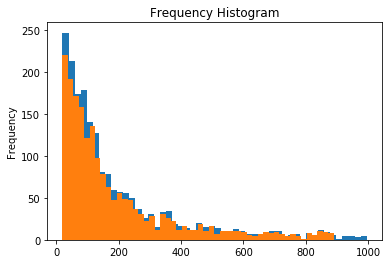

In [74]:
# Test divers size distribution avec desc_numeric or sent_numeric
display(len(desc_numeric))

lens = [len(d) for d in desc_numeric]
plt.hist(lens, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
# u,c = np.unique(lens, return_counts=True)
# display(u,c)

lens_filtered = [l for l in lens if 15 <= l <= 900]
display(len(lens_filtered))
plt.hist(lens_filtered, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [72]:
# Quick training test for the text
samples = output_preprocessor
labels = torch.randint(low=0,high=2,size=(samples.size(0),1)).float() 
train_dataset = MyDataset(samples, labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
discri_test2 = CNNDiscriminator(voc_size=len(vocabulary)+1)

total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    
    for i, (sentences, labels) in enumerate(train_loader):
        
        # Run the forward pass
        outputs = discri_test2(sentences)
        true_probability = outputs[:,1].unsqueeze(1)
        loss = criterion(true_probability, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data,1)
        predicted = predicted.unsqueeze(1)
        correct = (predicted == labels).sum().item() 
        acc_list.append(correct / total)
        
        # Print the results 
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/1], Step [1/291], Loss: 0.6951, Accuracy: 50.00%
Epoch [1/1], Step [2/291], Loss: 0.6996, Accuracy: 37.50%
Epoch [1/1], Step [3/291], Loss: 0.6977, Accuracy: 25.00%
Epoch [1/1], Step [4/291], Loss: 0.7069, Accuracy: 25.00%
Epoch [1/1], Step [5/291], Loss: 0.6956, Accuracy: 25.00%
Epoch [1/1], Step [6/291], Loss: 0.6986, Accuracy: 37.50%
Epoch [1/1], Step [7/291], Loss: 0.6891, Accuracy: 50.00%
Epoch [1/1], Step [8/291], Loss: 0.6893, Accuracy: 62.50%
Epoch [1/1], Step [9/291], Loss: 0.6893, Accuracy: 62.50%
Epoch [1/1], Step [10/291], Loss: 0.6887, Accuracy: 75.00%


KeyboardInterrupt: 